**Практическое задание №3 по курсу "Методы и технологии машинного обучения"**

*Арешин Станислав Олегович М8О-111М-21*

**Задание**

* Реализовать модель классификации на основе нейронной сети (MLP Classifier)

* Реализовать модели классификации на основе бэггинга (Bagging Classifier) и бустинга (Catboost). Определить оптимальное кол-во базовых моделей.

* Сравнить полученные результаты.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

%matplotlib inline

# Предобработка

## Загрузка данных

В этой лабораторной работе я решил поменять датасет, так как данные из прошлого датасета были недостаточно хорошего качества и их было мало.

Датасет https://www.kaggle.com/tejashvi14/employee-future-prediction

Отдел кадров компании хочет предсказать, покинут ли некоторые сотрудники компанию в ближайшие 2 года. Задача - построить прогностическую модель, предсказывающую перспективы будущего и настоящего сотрудника.

In [4]:
df = pd.read_csv('Employee.csv')
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


Пропущенных значений нет, всего 8 признаков, из них 4 категориальных, остальные числовые

## Баланс целевой величины

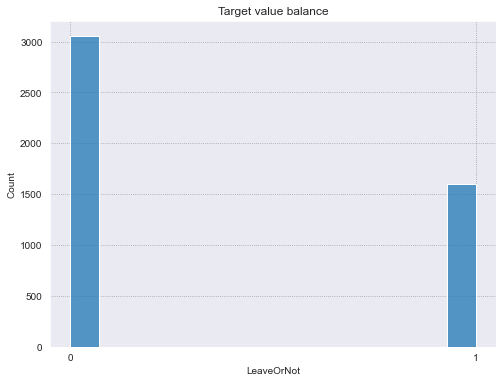

In [24]:
plt.figure(figsize=(8,6))
plt.title('Target value balance')
sns.histplot(data=df, x='LeaveOrNot')
plt.xticks([0,1])
plt.show()

Баланс целевой величины плохой, примерно 2:1. Так как задача учебная, обрежем данные до баланса 50 на 50.

In [31]:
'''
Функция балансировки по целевой величине 
Пока только для бинарной целевой величины 
'''
def balance_data_by_target(df, target):
    df_true = df[df[target] == 0].copy()
    df_false = df[df[target] == 1].copy()
    # перемешаем 3 раза
    for i in range(3):
        df_true = df_true.sample(frac=1).reset_index(drop=True)
        df_false = df_false.sample(frac=1).reset_index(drop=True)    
    if len(df_true) > len(df_false):
        df_true = df_true[:len(df_false)]
    else:
        df_false = df_false[:len(df_true)]
    # конкатенация
    df_res = pd.concat([df_true, df_false], axis = 0, ignore_index=True)
    # перемешаем 5 раз
    for i in range(5):
        df_res = df_res.sample(frac=1).reset_index(drop=True)  
    return df_res

In [32]:
df_cut = balance_data_by_target(df, target = 'LeaveOrNot')
df_cut.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,PHD,2015,Pune,3,37,Male,No,2,0
1,Bachelors,2014,Pune,3,37,Female,No,5,1
2,Bachelors,2015,Pune,3,28,Female,No,3,1
3,Bachelors,2012,Bangalore,3,31,Female,No,3,0
4,Bachelors,2015,Pune,2,27,Female,Yes,5,1


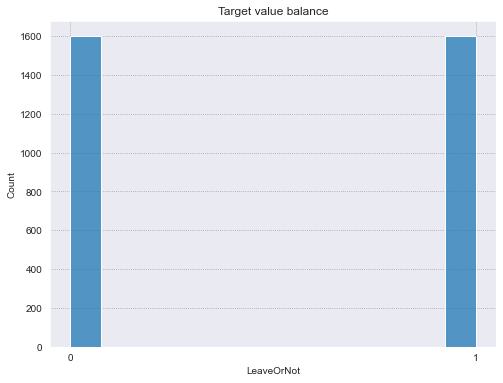

In [33]:
plt.figure(figsize=(8,6))
plt.title('Target value balance')
sns.histplot(data=df_cut, x='LeaveOrNot')
plt.xticks([0,1])
plt.show()

Теперь баланс целевой величины 50 на 50, осталось 3200 элементов выборки. Это здорово, так как теперь можно оценивать алгоритмы по accuracy.  Сохраним полученный датасет.

In [36]:
df_cut.to_csv('Employee_cut.csv', index=False)

## Частотность категориальных признаков

Посмотрим на частотность категориальных признаков, так как деревья не очень хорошо работают с редкими категориями. 

In [38]:
df_cut.select_dtypes(include='object').head()

,Education,City,Gender,EverBenched
0,PHD,Pune,Male,No
1,Bachelors,Pune,Female,No
2,Bachelors,Pune,Female,No
3,Bachelors,Bangalore,Female,No
4,Bachelors,Pune,Female,Yes


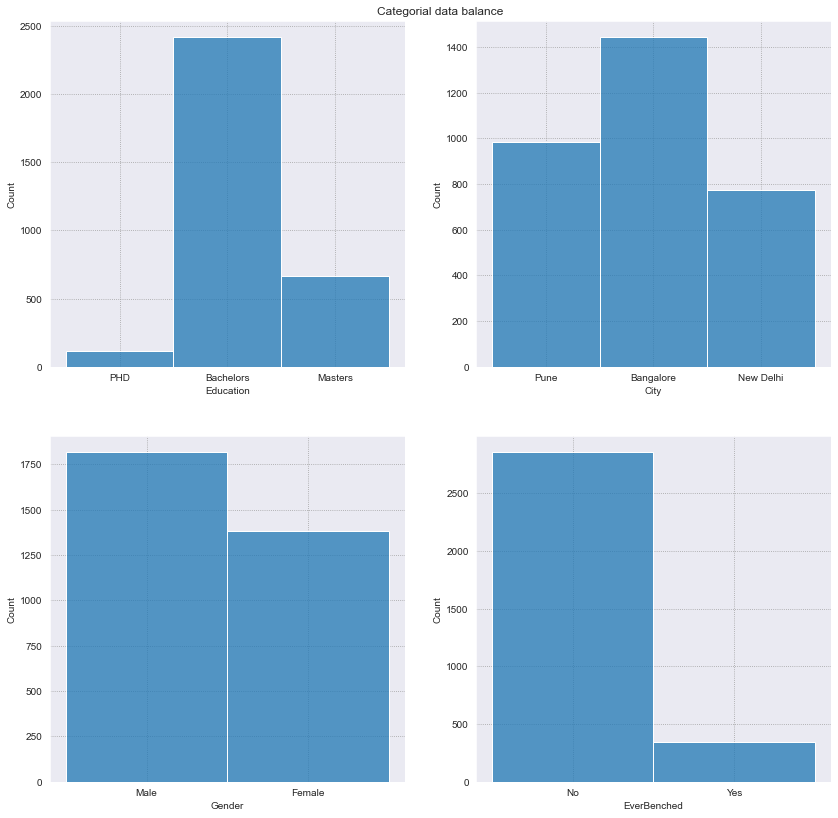

In [40]:
fig = plt.figure(figsize=(14,14))
plt.title('Categorial data balance')
plt.axis('off')

for i, column in enumerate(df_cut.select_dtypes(include='object').columns):
    ax = fig.add_subplot(2, 2, i + 1)
    sns.histplot(data=df_cut, x=column)

Категории признаков EverBenched и Education очень плохо сбалансированы. Признак EverBenched означает, был ли работник уволен хоть раз до этого. Его удалять нельзя, так как это должно вносить существенный вклад в ответ алгоритма. Признак Education - образование. Очень непопулярная категория PHD, больше всех бакалавров. Кажется, что если человек имеет степень PHD, это важно, поэтому также не будем ничего удалять.

## One Hot Encoding

Категориальные признаки было решено закодировать с помощью One Hot Encoding, чтобы максимально сохранить информацию, которую они несут.

In [44]:
df_encoded = pd.get_dummies(df_cut)
df_encoded.head()

,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,LeaveOrNot,Education_Bachelors,Education_Masters,Education_PHD,City_Bangalore,City_New Delhi,City_Pune,Gender_Female,Gender_Male,EverBenched_No,EverBenched_Yes
0,2015,3,37,2,0,0,0,1,0,0,1,0,1,1,0
1,2014,3,37,5,1,1,0,0,0,0,1,1,0,1,0
2,2015,3,28,3,1,1,0,0,0,0,1,1,0,1,0
3,2012,3,31,3,0,1,0,0,1,0,0,1,0,1,0
4,2015,2,27,5,1,1,0,0,0,0,1,1,0,0,1


In [46]:
df_cut.shape, df_encoded.shape

((3200, 9), (3200, 15))

## Выделение целевой величины

In [47]:
y = df_encoded['LeaveOrNot'].to_numpy()
X = df_encoded.drop(['LeaveOrNot'], axis = 1).to_numpy()

X.shape, y.shape

((3200, 14), (3200,))

## Train-test split

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,
                                                    random_state = 42,  stratify = y)

In [56]:
X_train.shape, y_train.shape

((2400, 14), (2400,))

In [57]:
X_test.shape, y_test.shape

((800, 14), (800,))

# Bagging Classifier

## Baseline

Сначала построим бейслайн алгоритма из sklearn, чтобы было качество, на которое можно ориентироваться, а затем переберем количество базовых моделей с помощью Grid Search на кросс-валидации.

In [100]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report

model = BaggingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.82      0.79       400
           1       0.80      0.74      0.77       400

    accuracy                           0.78       800
   macro avg       0.78      0.78      0.78       800
weighted avg       0.78      0.78      0.78       800



## Grid Serach

Количество базовых моделей было решено перебирать от дефолтных 20 до 200 с шагом 10.

In [102]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier

grid = {
    'n_estimators' : np.arange(20, 210, step = 10)
    }

model = BaggingClassifier()

gs = GridSearchCV(model, param_grid=grid, scoring='accuracy', cv = 5, n_jobs=-1)

gs.fit(X_train, y_train)

gs.best_params_, gs.best_score_

({'n_estimators': 160}, 0.7795833333333333)

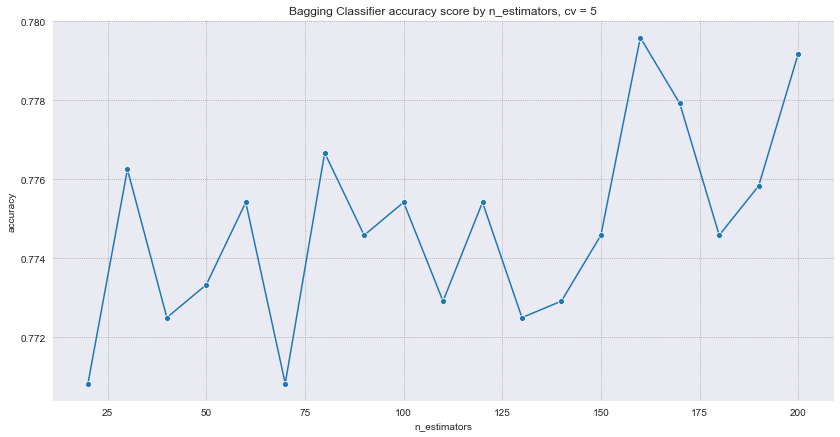

In [103]:
plt.figure(figsize=(14,7))
plt.title('Bagging Classifier accuracy score by n_estimators, cv = 5')

sns.lineplot(x = grid['n_estimators'], y = gs.cv_results_['mean_test_score'], marker ='o')

plt.xlabel('n_estimators')
plt.ylabel('accuracy')

plt.show()

## Best model

Лучшим результатом стало количество базовых моделей $n\_estimators = 160$, используем этот гиперпараметр для обучения лучшей модели.

In [104]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report

model = BaggingClassifier(n_estimators = 160)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80       400
           1       0.82      0.75      0.78       400

    accuracy                           0.79       800
   macro avg       0.79      0.79      0.79       800
weighted avg       0.79      0.79      0.79       800



Получен прирост примерно + 0.01 к accuracy модели за счёт увеличения количества базовых моделей в Bagging Classifier, больший прирост можно получить, перебирая параметры самих базовых моделей, но это достаточно долго. 

# Catboost Classifier


## Baseline 

CatBoost хорош тем, что по дефолту подбирает хорошие гиперпараметры модели (если открыть документацию, везде стоит None). Возьмем за бейслайн CatBoost из бибилиотеки.

In [121]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

model = CatBoostClassifier(early_stopping_rounds=50, verbose = False)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.89      0.82       400
           1       0.87      0.73      0.79       400

    accuracy                           0.81       800
   macro avg       0.82      0.81      0.81       800
weighted avg       0.82      0.81      0.81       800



## Grid Serach

Аналогично по сетке переберем количество базовых моделей от 20 до 200 с шагом 10.

In [115]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

grid = {
    'n_estimators' : np.arange(20, 210, step = 10)
    }

model = CatBoostClassifier(early_stopping_rounds=50, verbose = False)

gs = GridSearchCV(model, param_grid=grid, scoring='accuracy', cv = 5, n_jobs=-1)

gs.fit(X_train, y_train)

gs.best_params_, gs.best_score_

({'n_estimators': 40}, 0.8150000000000001)

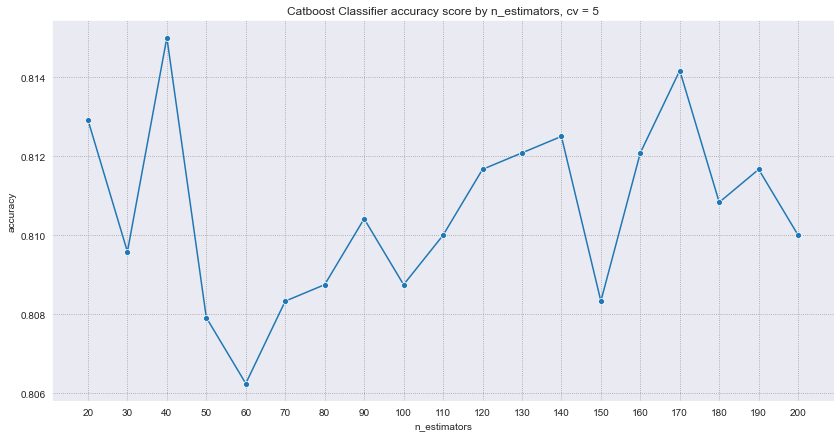

In [117]:
plt.figure(figsize=(14,7))
plt.title('Catboost Classifier accuracy score by n_estimators, cv = 5')

sns.lineplot(x = grid['n_estimators'], y = gs.cv_results_['mean_test_score'], marker ='o')

plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(grid['n_estimators'])

plt.show()

## Best model

Лучшим результатом стало количество базовых моделей $n\_estimators = 40$, используем этот гиперпараметр для обучения лучшей модели.

In [118]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

model = CatBoostClassifier(n_estimators=40, early_stopping_rounds=50, verbose = False)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.89      0.82       400
           1       0.86      0.73      0.79       400

    accuracy                           0.81       800
   macro avg       0.82      0.81      0.81       800
weighted avg       0.82      0.81      0.81       800



После тюнинга алгоритма не заметен прирост к качеству классификатора. Можно было бы тоже попробовать перебрать сами параметры базовых моделей, но за счёт того, что CatBoost хорошо выбирает параметры, значительного прироста такой подход может не дать. Но,  когда важна каждая десятая в точности, этим стоит заняться.

# MLP Classifier

## Standart Scaler

Для алгоритмов, основанных на деревьях, масштаб признаков не так важен. Поэтому стандартизацию я не проводил. Но для MLP Classifier результат будет лучше, если признаки привести к одной шкале, так что используем Standart Scaler.

In [123]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_scaled = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25,
                                                    random_state = 42,  stratify = y)

## Baseline

В качестве основы используется стандартный алгоритм из sklearn, у него 1 скрытый слой со 100 нейронами.

In [140]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

model = MLPClassifier(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81       400
           1       0.84      0.73      0.78       400

    accuracy                           0.80       800
   macro avg       0.80      0.79      0.79       800
weighted avg       0.80      0.80      0.79       800



## Grid search

Чтобы перебрать количество скрытых слоев и нейронов в этих слоях я решил случайно сгенерировать сетку из 20 вариантов с кол-вом слоев от 1 до 3 и кол-вом нейронов от 100 до 200.

In [177]:
grid = {
    'hidden_layer_sizes' : [tuple([stats.randint.rvs(100,200,1) for _ in range(stats.randint.rvs(0,3,1))]) 
                            for _ in range(20)]
    }

grid

{'hidden_layer_sizes': [(129, 183),
  (109, 169, 138),
  (118, 104),
  (173,),
  (174, 150),
  (115, 168),
  (198, 134, 113),
  (142, 131, 200),
  (177, 118, 132),
  (133,),
  (105, 155, 182),
  (111, 145, 127),
  (108, 139, 175),
  (190,),
  (161,),
  (123, 173),
  (157, 113, 127),
  (157, 136),
  (193,),
  (196, 193, 114)]}

In [178]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from scipy import stats

model = MLPClassifier(max_iter=1000)

gs = GridSearchCV(model, param_grid=grid,  scoring='accuracy', cv = 3, n_jobs=-1)

gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=1000), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(129, 183), (109, 169, 138),
                                                (118, 104), (173,), (174, 150),
                                                (115, 168), (198, 134, 113),
                                                (142, 131, 200),
                                                (177, 118, 132), (133,),
                                                (105, 155, 182),
                                                (111, 145, 127),
                                                (108, 139, 175), (190,), (161,),
                                                (123, 173), (157, 113, 127),
                                                (157, 136), (193,),
                                                (196, 193, 114)]},
             scoring='accuracy')

In [179]:
gs.best_params_, gs.best_score_

({'hidden_layer_sizes': (173,)}, 0.7954166666666667)

In [186]:
[str(i) for i in grid['hidden_layer_sizes']]

['(129, 183)',
 '(109, 169, 138)',
 '(118, 104)',
 '(173,)',
 '(174, 150)',
 '(115, 168)',
 '(198, 134, 113)',
 '(142, 131, 200)',
 '(177, 118, 132)',
 '(133,)',
 '(105, 155, 182)',
 '(111, 145, 127)',
 '(108, 139, 175)',
 '(190,)',
 '(161,)',
 '(123, 173)',
 '(157, 113, 127)',
 '(157, 136)',
 '(193,)',
 '(196, 193, 114)']

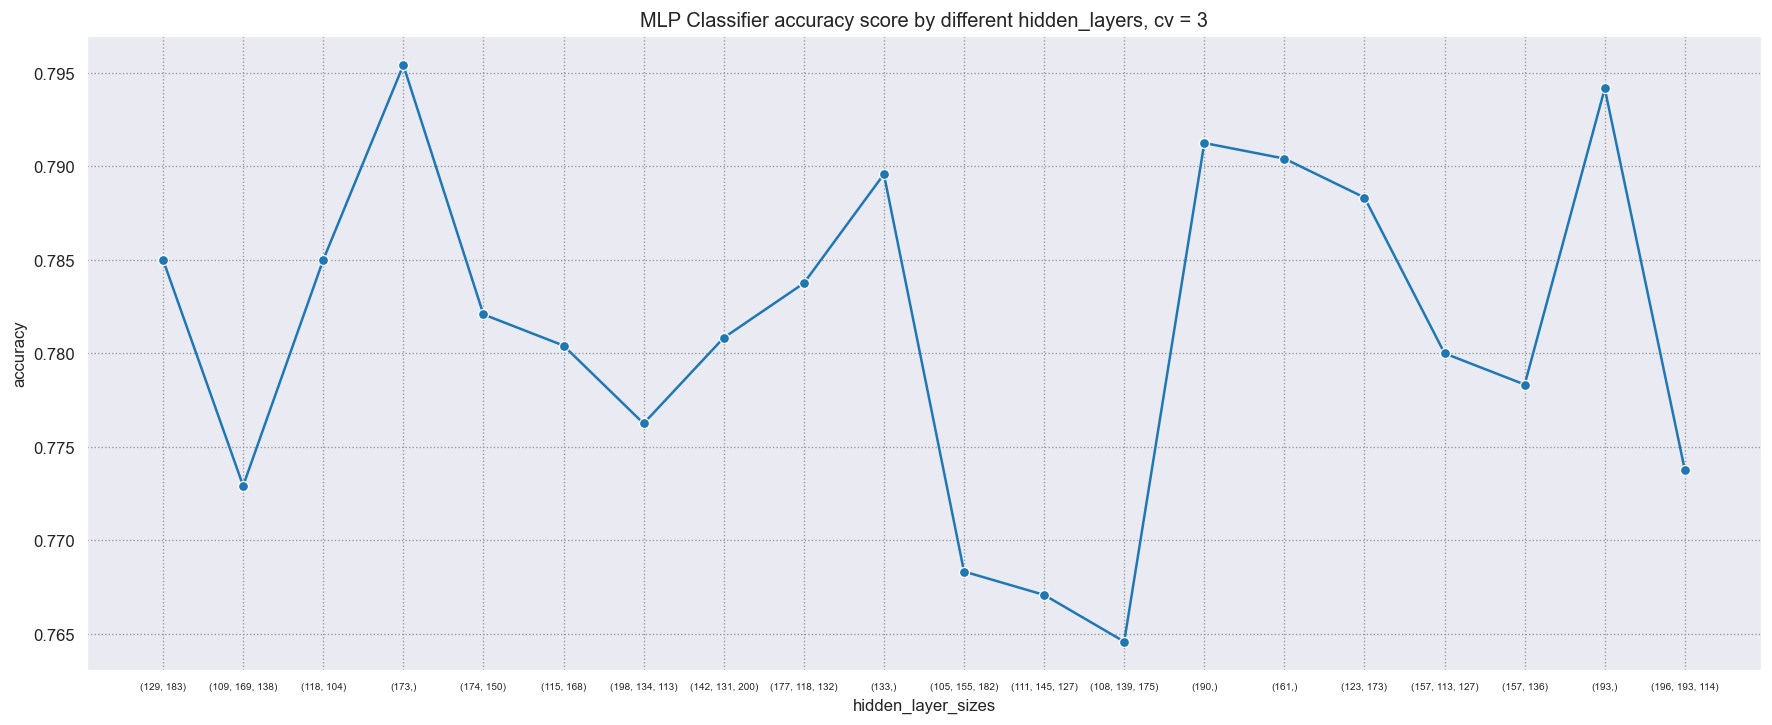

In [202]:
fig = plt.figure(figsize=(18,7))
fig.set_dpi(120)
plt.title('MLP Classifier accuracy score by different hidden_layers, cv = 3')

ax = sns.lineplot(x = range(len(grid['hidden_layer_sizes'])), y = gs.cv_results_['mean_test_score'], marker ='o')

plt.xlabel('hidden_layer_sizes')
plt.ylabel('accuracy')
ax.set_xticks(range(len(grid['hidden_layer_sizes'])))
ax.set_xticklabels([str(i) for i in grid['hidden_layer_sizes']], fontsize = 6)
plt.show()

## Best model

Лучшие параметры это 1 слой со 173 нейронами, при этом скор на кросс валидации меньше, чем у бейслайна. Попробуем обучить модель.

In [180]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

model = MLPClassifier(hidden_layer_sizes = (173), max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81       400
           1       0.86      0.71      0.78       400

    accuracy                           0.80       800
   macro avg       0.80      0.79      0.79       800
weighted avg       0.80      0.80      0.79       800



Снова не заметен прирост к точности, но это можно объяснить тем, что модели очень похожи, так как они обе содержат один слой и отличаются только количеством нейронов. При усложнении модели увеличением кол-ва слоев заметно падает точность, поэтому оставим лучшую модель такой.

# Выводы

По результатам проделанных экспериментов лучшим оказался CatBoost Classifier, его accuracy 0.81, затем MLP Classifier с 0.8 accuracy и затем Bagging Classifier c accuracy 0.79. У каждого алгоритма качество можно улучшить дополнительным перебором гиперпараметров. У CatBoost и Bagging хорошо было бы перебрать параметры построения деревьев для базовых моделей. У MLP можно минимизировать случайность в выборе параметров, перебрать функции активации, параметр l2 регуляризации, размер батча и т.д. В целом все рассмотренные алгоритмы показывают хорошее качество на выбранном датасете, так как я пробовал логистическую регрессию "из коробки", её скор был 0.68. Важно отметить, что в каждом случае перебор одного выбранного гиперпараметра практически не давал прироста к качеству модели, что говорит о необходимости более сложного перебора, но к сожалению, это очень долго.